In [58]:
# Cell 1: Imports and Configuration
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, mean_squared_error, roc_auc_score, 
    log_loss, brier_score_loss
)

# Add custom model path
# Removed old path hack; using package imports))
from llm_prior_project.priors.target_informed_model import TargetInformedModel

# Set style and random seed
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

# Configuration
CONFIG = {
    'random_state': 42,
    'test_size': 0.2,
    'alpha_default': 1.0
}

In [59]:
# Cell 2: Data Loading Functions
def load_heart_dataset(
    path: str, 
    features: List[str], 
    outcome: str = "num"
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Load and preprocess heart disease dataset.
    
    Args:
        path: Path to the dataset file
        features: List of feature names to use
        outcome: Target column name
    
    Returns:
        X: Feature dataframe
        y: Target series (binary: 0=no disease, 1=disease)
    """
    columns = [
        "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
        "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
    ]
    
    # Load data
    df = pd.read_csv(path, header=None, names=columns, na_values="?")
    
    # Convert to binary classification
    df[outcome] = (df[outcome] > 0).astype(int)
    
    # Select features and drop missing values
    df = df[features + [outcome]].dropna()
    
    return df[features], df[outcome]


def create_feature_name_map(feature_names: List[str]) -> Dict[str, str]:
    """Create human-readable feature name mappings."""
    name_map = {
        "age": "Age (years)",
        "sex": "Sex (1=male, 0=female)",
        "trestbps": "Resting Blood Pressure (mm Hg)",
        "chol": "Serum Cholesterol (mg/dl)",
        "thalach": "Maximum Heart Rate",
        "oldpeak": "ST Depression",
        "exang": "Exercise Induced Angina",
        "fbs": "Fasting Blood Sugar > 120 mg/dl"
    }
    
    # Add one-hot encoded features
    for col in feature_names:
        if col not in name_map:
            if col.startswith("cp_"):
                name_map[col] = f"Chest Pain Type {col.split('_')[1]}"
            elif col.startswith("restecg_"):
                name_map[col] = f"Resting ECG Code {col.split('_')[1]}"
    
    return name_map

In [60]:
# Cell 3: Load and Combine Datasets
# Define features to use
RAW_FEATURES = [
    "age", "sex", "trestbps", "chol", "thalach",
    "oldpeak", "cp", "exang", "fbs", "restecg"
]

# Load Cleveland and Hungarian datasets
X_cleveland, y_cleveland = load_heart_dataset(
    "data/heart+disease/processed.cleveland.data", 
    RAW_FEATURES
)
X_hungarian, y_hungarian = load_heart_dataset(
    "data/heart+disease/processed.hungarian.data", 
    RAW_FEATURES
)

print(f"Cleveland dataset: {X_cleveland.shape[0]} samples")
print(f"Hungarian dataset: {X_hungarian.shape[0]} samples")

Cleveland dataset: 303 samples
Hungarian dataset: 261 samples


In [61]:
# Cell 4: Preprocessing Pipeline
def preprocess_features(
    X_clev: pd.DataFrame, 
    X_hun: pd.DataFrame,
    y_clev: pd.Series,
    y_hun: pd.Series
) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    """
    Preprocess and combine datasets with one-hot encoding.
    
    Returns:
        X_combined: Combined feature matrix
        y_combined: Combined target vector
        feature_names: List of all feature names after preprocessing
    """
    # One-hot encode categorical variables
    categorical_cols = ["cp", "restecg"]
    
    X_clev_encoded = pd.get_dummies(
        X_clev, columns=categorical_cols, drop_first=True
    ).astype(float)
    X_hun_encoded = pd.get_dummies(
        X_hun, columns=categorical_cols, drop_first=True
    ).astype(float)
    
    # Clean column names (remove .0 suffix)
    for df in [X_clev_encoded, X_hun_encoded]:
        df.columns = [col.replace(".0", "") for col in df.columns]
    
    # Align columns between datasets
    all_columns = sorted(
        set(X_clev_encoded.columns) | set(X_hun_encoded.columns)
    )
    X_clev_aligned = X_clev_encoded.reindex(columns=all_columns, fill_value=0.0)
    X_hun_aligned = X_hun_encoded.reindex(columns=all_columns, fill_value=0.0)
    
    # Combine datasets
    X_combined = pd.concat([X_clev_aligned, X_hun_aligned], axis=0, ignore_index=True)
    y_combined = pd.concat([y_clev, y_hun], axis=0, ignore_index=True).astype(int)
    
    return X_combined, y_combined, list(X_combined.columns)

# Apply preprocessing
X_all, y_all, feature_names = preprocess_features(
    X_cleveland, X_hungarian, y_cleveland, y_hungarian
)

print(f"\nCombined dataset shape: {X_all.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Class distribution: {y_all.value_counts().to_dict()}")


Combined dataset shape: (564, 13)
Number of features: 13
Class distribution: {0: 327, 1: 237}


In [62]:
# Cell 5: Split Data by Sex
def split_by_sex(
    X: pd.DataFrame, 
    y: pd.Series
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Split data by sex and remove sex column from features.
    
    Returns:
        Dictionary with 'male' and 'female' keys, each containing:
        - 'X': Feature matrix without sex column
        - 'y': Target vector
        - 'indices': Original indices
    """
    if "sex" not in X.columns:
        raise ValueError("Sex column not found in features")
    
    # Create masks
    male_mask = (X["sex"] == 1).values
    female_mask = (X["sex"] == 0).values
    
    # Get feature names without sex
    sex_idx = list(X.columns).index("sex")
    features_no_sex = [f for f in X.columns if f != "sex"]
    
    # Split and remove sex column
    data_splits = {
        'male': {
            'X': X.loc[male_mask, features_no_sex].values,
            'y': y[male_mask].values,
            'indices': np.where(male_mask)[0]
        },
        'female': {
            'X': X.loc[female_mask, features_no_sex].values,
            'y': y[female_mask].values,
            'indices': np.where(female_mask)[0]
        }
    }
    
    return data_splits, features_no_sex, sex_idx

# Split the data
data_by_sex, features_no_sex, sex_column_idx = split_by_sex(X_all, y_all)

print("Data split by sex:")
print(f"  Male samples: {len(data_by_sex['male']['y'])}")
print(f"  Female samples: {len(data_by_sex['female']['y'])}")
print(f"  Features (excluding sex): {len(features_no_sex)}")

Data split by sex:
  Male samples: 398
  Female samples: 166
  Features (excluding sex): 12


In [67]:
# Cell 6: Define Target Coefficients
def create_target_coefficients(features_list):
    """
    Define domain-knowledge based target coefficients for each sex.
    Maps coefficients to actual feature names to ensure proper alignment.
    """
    # Define coefficient mappings for known features
    male_coef_map = {
        'age': 0.52,
        'trestbps': 0.41,
        'chol': 0.18,
        'thalach': 0.33,
        'oldpeak': -0.28,
        'exang': 0.57,
        'fbs': 0.12,
        'cp_2': 0.23,
        'cp_3': -0.63,
        'cp_4': 0.82,
        'restecg_1': -0.47,
        'restecg_2': 0.91
    }
    
    female_coef_map = {
        'age': 0.35,
        'trestbps': 0.20,
        'chol': 0.15,
        'thalach': 0.15,
        'oldpeak': -0.10,
        'exang': 0.45,
        'fbs': 0.25,
        'cp_2': 0.10,
        'cp_3': -0.40,
        'cp_4': 0.50,
        'restecg_1': -0.20,
        'restecg_2': 0.30
    }
    
    # Build arrays matching the exact feature order
    target_male = np.array([male_coef_map.get(feat, 0.0) for feat in features_list])
    target_female = np.array([female_coef_map.get(feat, 0.0) for feat in features_list])
    
    return {'male': target_male, 'female': target_female}

# Create targets aligned with features_no_sex (already has sex removed)
targets = create_target_coefficients(features_no_sex)

print(f"Number of features (no sex): {len(features_no_sex)}")
print(f"Target coefficient dimensions - Male: {targets['male'].shape}")
print(f"Target coefficient dimensions - Female: {targets['female'].shape}")

# Verify alignment
print("\nFeature-Coefficient alignment check:")
for i, feat in enumerate(features_no_sex):
    print(f"{feat:15s} -> Male: {targets['male'][i]:6.2f}, Female: {targets['female'][i]:6.2f}")
    

Number of features (no sex): 12
Target coefficient dimensions - Male: (12,)
Target coefficient dimensions - Female: (12,)

Feature-Coefficient alignment check:
age             -> Male:   0.52, Female:   0.35
chol            -> Male:   0.18, Female:   0.15
cp_2            -> Male:   0.23, Female:   0.10
cp_3            -> Male:  -0.63, Female:  -0.40
cp_4            -> Male:   0.82, Female:   0.50
exang           -> Male:   0.57, Female:   0.45
fbs             -> Male:   0.12, Female:   0.25
oldpeak         -> Male:  -0.28, Female:  -0.10
restecg_1       -> Male:  -0.47, Female:  -0.20
restecg_2       -> Male:   0.91, Female:   0.30
thalach         -> Male:   0.33, Female:   0.15
trestbps        -> Male:   0.41, Female:   0.20


In [68]:
# Cell 7: Model Training and Evaluation Class
class GenderCrossValidator:
    """Handle training on one gender and testing on another."""
    
    def __init__(self, alpha: float = 1.0):
        self.alpha = alpha
        self.results = {}
        
    def train_and_evaluate(
        self,
        train_data: Dict,
        test_data: Dict,
        target_coef: np.ndarray,
        feature_names: List[str],
        experiment_name: str
    ) -> Dict:
        """
        Train model on one group and evaluate on another.
        
        Args:
            train_data: Dictionary with 'X' and 'y' for training
            test_data: Dictionary with 'X' and 'y' for testing
            target_coef: Target coefficients for regularization
            feature_names: List of feature names
            experiment_name: Name for this experiment
        
        Returns:
            Dictionary of evaluation metrics
        """
        # Standardize features
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(train_data['X'])
        X_test_std = scaler.transform(test_data['X'])
        
        # Train model
        model = TargetInformedModel(
            alpha=self.alpha,
            model_type="ridge",
            fit_intercept=True,
            targets=target_coef
        )
        model.fit(X_train_std, train_data['y'], feature_names=feature_names)
        
        # Make predictions
        y_pred = model.predict(X_test_std)
        y_pred_prob = self._sigmoid(y_pred)
        
        # Calculate metrics
        metrics = {
            'r2': r2_score(test_data['y'], y_pred),
            'mse': mean_squared_error(test_data['y'], y_pred),
            'auc': roc_auc_score(test_data['y'], y_pred_prob),
            'log_loss': log_loss(test_data['y'], np.clip(y_pred_prob, 1e-9, 1-1e-9)),
            'brier': brier_score_loss(test_data['y'], y_pred_prob)
        }
        
        # Store results
        self.results[experiment_name] = {
            'metrics': metrics,
            'model': model,
            'scaler': scaler,
            'predictions': y_pred,
            'probabilities': y_pred_prob,
            'coefficients': model.get_coefficient_summary()
        }
        
        return metrics
    
    @staticmethod
    def _sigmoid(x):
        """Apply sigmoid transformation for probability output."""
        return 1 / (1 + np.exp(-x))
    
    def print_results(self, experiment_name: str):
        """Print formatted results for an experiment."""
        if experiment_name not in self.results:
            print(f"No results found for {experiment_name}")
            return
        
        metrics = self.results[experiment_name]['metrics']
        print(f"\n{'='*50}")
        print(f"Experiment: {experiment_name}")
        print(f"{'='*50}")
        print(f"R² Score:     {metrics['r2']:.4f}")
        print(f"MSE:          {metrics['mse']:.4f}")
        print(f"AUC:          {metrics['auc']:.4f}")
        print(f"Log Loss:     {metrics['log_loss']:.4f}")
        print(f"Brier Score:  {metrics['brier']:.4f}")

In [69]:
# Cell 8: Run Cross-Gender Experiments
validator = GenderCrossValidator(alpha=1.0)

# Experiment 1: Train on Male → Test on Female
metrics_m2f = validator.train_and_evaluate(
    train_data=data_by_sex['male'],
    test_data=data_by_sex['female'],
    target_coef=targets['male'],
    feature_names=features_no_sex,
    experiment_name="Male→Female"
)
validator.print_results("Male→Female")

# Experiment 2: Train on Female → Test on Male
metrics_f2m = validator.train_and_evaluate(
    train_data=data_by_sex['female'],
    test_data=data_by_sex['male'],
    target_coef=targets['female'],
    feature_names=features_no_sex,
    experiment_name="Female→Male"
)
validator.print_results("Female→Male")


Experiment: Male→Female
R² Score:     0.1192
MSE:          0.1526
AUC:          0.8632
Log Loss:     0.7627
Brier Score:  0.2847

Experiment: Female→Male
R² Score:     0.2201
MSE:          0.1950
AUC:          0.8433
Log Loss:     0.6280
Brier Score:  0.2188


In [72]:
# Cell 7: Reverse experiment (train=female → test=male)
print_section("Target-Informed Ridge: Train on Female, Test on Male")

X_train, y_train = X_np[female_mask], y_np[female_mask]
X_test, y_test = X_np[male_mask], y_np[male_mask]

# Remove sex column
sex_idx = feature_names.index("sex")
X_train = np.delete(X_train, sex_idx, axis=1)
X_test = np.delete(X_test, sex_idx, axis=1)

# Use the targets we already created (they already have sex removed)
t_train = targets['female']  # Use female targets for training on females
t_test_ref = targets['male']  # Reference for male (not used in training)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

model_ti_rev = TargetInformedModel(
    alpha=1.0,
    model_type="ridge",
    fit_intercept=True,
    targets=t_train
)

# Use features_no_sex instead of feat_no_sex
model_ti_rev.fit(X_train_std, y_train, feature_names=features_no_sex)

y_pred = model_ti_rev.predict(X_test_std)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2:  {r2:.4f}")
print(f"MSE:  {mse:.4f}")


Target-Informed Ridge: Train on Female, Test on Male
R^2:  0.2201
MSE:  0.1950


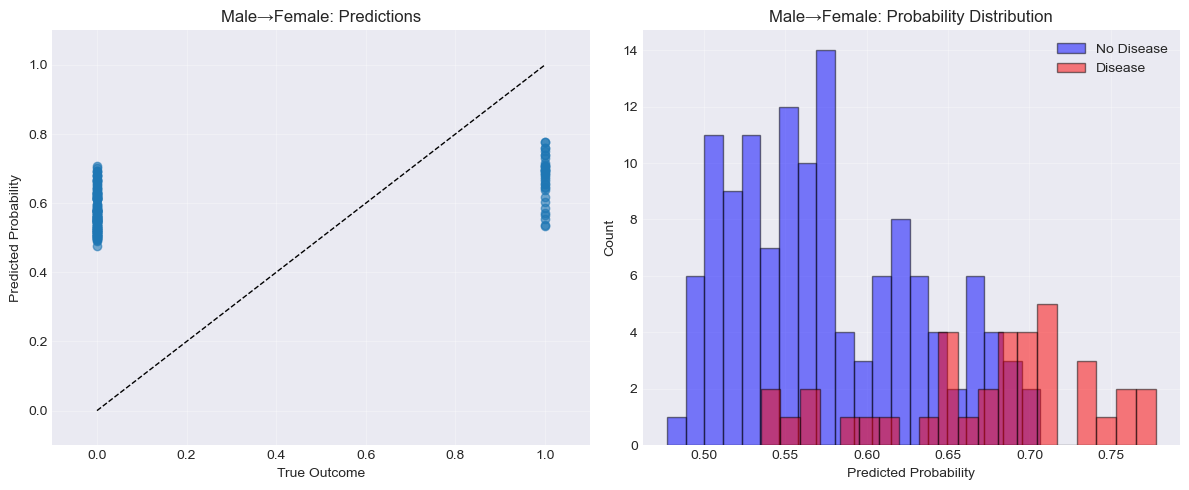


Male→Female Prediction Statistics:
  Mean prediction (No Disease): 0.576
  Mean prediction (Disease):    0.674
  Prediction range: [0.478, 0.777]


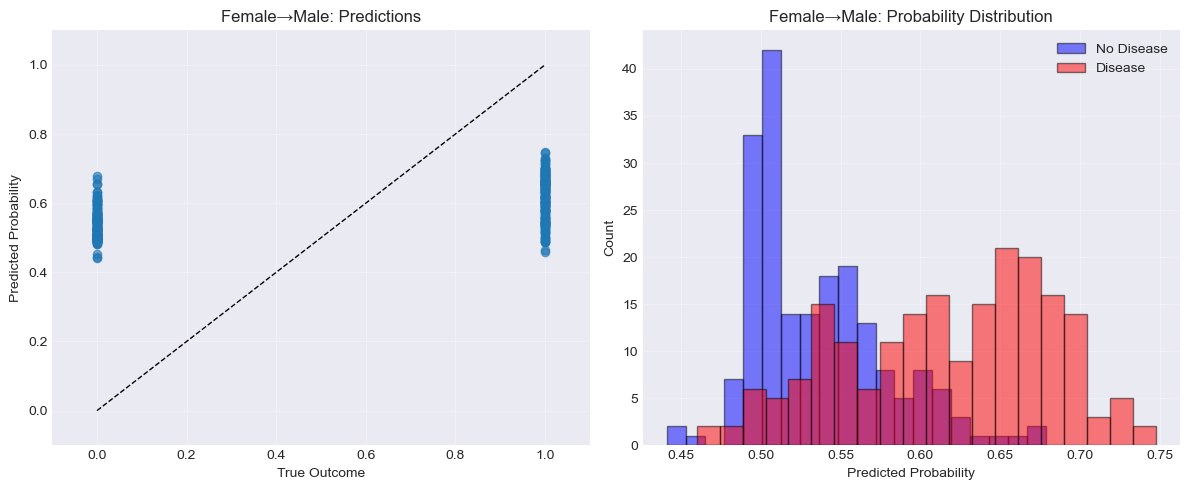


Female→Male Prediction Statistics:
  Mean prediction (No Disease): 0.535
  Mean prediction (Disease):    0.617
  Prediction range: [0.441, 0.747]


In [74]:
# Cell 9: Visualization Functions
def plot_predictions(validator: GenderCrossValidator, experiment_name: str):
    """Plot true vs predicted values."""
    if experiment_name not in validator.results:
        print(f"No results found for {experiment_name}")
        return
    
    results = validator.results[experiment_name]
    
    # Determine which test set was used based on experiment name
    if "→Female" in experiment_name:
        y_true = data_by_sex['female']['y']
    else:  # "→Male" in experiment_name
        y_true = data_by_sex['male']['y']
    
    y_pred = results['probabilities']
    
    # Verify dimensions match
    if len(y_true) != len(y_pred):
        print(f"Dimension mismatch: y_true has {len(y_true)} samples, y_pred has {len(y_pred)} samples")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot
    ax1.scatter(y_true, y_pred, alpha=0.6)
    ax1.plot([0, 1], [0, 1], 'k--', lw=1)
    ax1.set_xlabel('True Outcome')
    ax1.set_ylabel('Predicted Probability')
    ax1.set_title(f'{experiment_name}: Predictions')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_ylim(-0.1, 1.1)
    
    # Distribution plot
    ax2.hist(y_pred[y_true == 0], bins=20, alpha=0.5, label='No Disease', color='blue', edgecolor='black')
    ax2.hist(y_pred[y_true == 1], bins=20, alpha=0.5, label='Disease', color='red', edgecolor='black')
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('Count')
    ax2.set_title(f'{experiment_name}: Probability Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{experiment_name} Prediction Statistics:")
    print(f"  Mean prediction (No Disease): {y_pred[y_true == 0].mean():.3f}")
    print(f"  Mean prediction (Disease):    {y_pred[y_true == 1].mean():.3f}")
    print(f"  Prediction range: [{y_pred.min():.3f}, {y_pred.max():.3f}]")

# Plot results for both experiments
plot_predictions(validator, "Male→Female")
plot_predictions(validator, "Female→Male")


Top adjusted features for Male→Female:


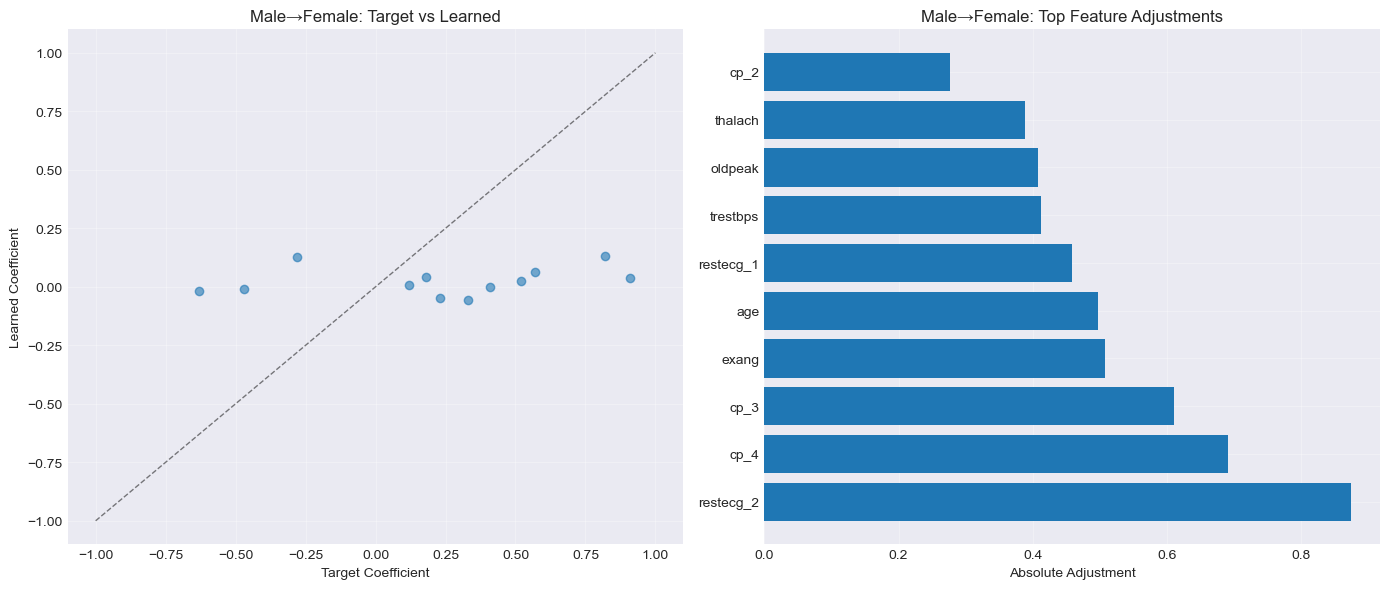

      feature  target  coefficient  adjustment
9   restecg_2    0.91     0.036630   -0.873370
4        cp_4    0.82     0.129514   -0.690486
3        cp_3   -0.63    -0.020057    0.609943
5       exang    0.57     0.062252   -0.507748
0         age    0.52     0.022857   -0.497143
8   restecg_1   -0.47    -0.011200    0.458800
11   trestbps    0.41    -0.002428   -0.412428
7     oldpeak   -0.28     0.127947    0.407947
10    thalach    0.33    -0.058211   -0.388211
2        cp_2    0.23    -0.046259   -0.276259

Top adjusted features for Female→Male:


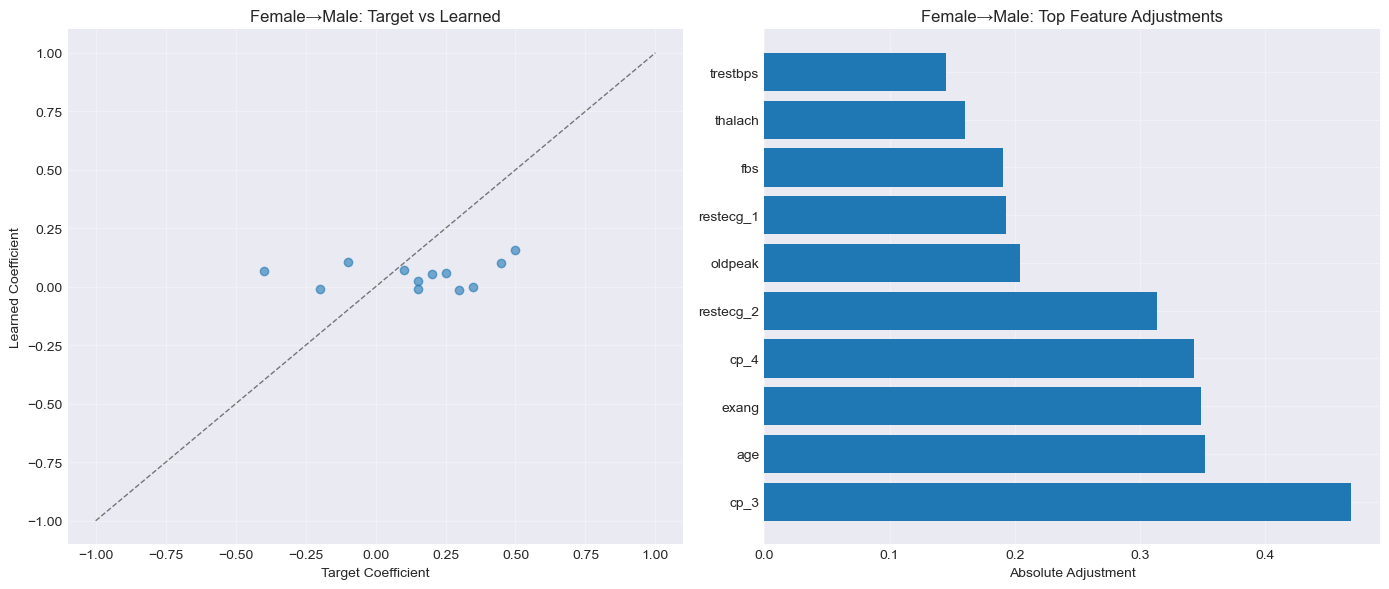

      feature  target  coefficient  adjustment
3        cp_3   -0.40     0.068143    0.468143
0         age    0.35    -0.001566   -0.351566
5       exang    0.45     0.100969   -0.349031
4        cp_4    0.50     0.156629   -0.343371
9   restecg_2    0.30    -0.013643   -0.313643
7     oldpeak   -0.10     0.104230    0.204230
8   restecg_1   -0.20    -0.007395    0.192605
6         fbs    0.25     0.059159   -0.190841
10    thalach    0.15    -0.009926   -0.159926
11   trestbps    0.20     0.055315   -0.144685


In [75]:
# Cell 10: Feature Importance Analysis
def analyze_feature_importance(validator: GenderCrossValidator, experiment_name: str, top_n: int = 10):
    """Analyze and visualize feature importance."""
    results = validator.results[experiment_name]
    coef_df = results['coefficients'].copy()
    
    # Calculate absolute adjustment
    coef_df['abs_adjustment'] = coef_df['adjustment'].abs()
    
    # Get top features by adjustment
    top_features = coef_df.nlargest(top_n, 'abs_adjustment')
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Target vs Learned Coefficients
    ax1.scatter(coef_df['target'], coef_df['coefficient'], alpha=0.6)
    ax1.plot([-1, 1], [-1, 1], 'k--', lw=1, alpha=0.5)
    ax1.set_xlabel('Target Coefficient')
    ax1.set_ylabel('Learned Coefficient')
    ax1.set_title(f'{experiment_name}: Target vs Learned')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Top adjustments
    ax2.barh(range(len(top_features)), top_features['abs_adjustment'].values)
    ax2.set_yticks(range(len(top_features)))
    ax2.set_yticklabels(top_features['feature'].values)
    ax2.set_xlabel('Absolute Adjustment')
    ax2.set_title(f'{experiment_name}: Top Feature Adjustments')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return top_features

# Analyze both experiments
print("\nTop adjusted features for Male→Female:")
top_m2f = analyze_feature_importance(validator, "Male→Female")
print(top_m2f[['feature', 'target', 'coefficient', 'adjustment']])

print("\nTop adjusted features for Female→Male:")
top_f2m = analyze_feature_importance(validator, "Female→Male")
print(top_f2m[['feature', 'target', 'coefficient', 'adjustment']])

In [ ]:
# Cell 11: Alpha Hyperparameter Tuning
def tune_alpha(
    train_data: Dict,
    test_data: Dict,
    target_coef: np.ndarray,
    feature_names: List[str],
    alphas: np.ndarray = None
) -> pd.DataFrame:
    """
    Perform alpha hyperparameter tuning.
    
    Args:
        train_data: Training data dictionary
        test_data: Test data dictionary
        target_coef: Target coefficients
        feature_names: Feature names
        alphas: Array of alpha values to test
    
    Returns:
        DataFrame with results for each alpha
    """
    if alphas is None:
        alphas = np.logspace(-2, 2, 20)  # 0.01 to 100
    
    results = []
    
    for alpha in alphas:
        cv = GenderCrossValidator(alpha=alpha)
        metrics = cv.train_and_evaluate(
            train_data, test_data, target_coef, 
            feature_names, f"alpha_{alpha:.3f}"
        )
        
        results.append({
            'alpha': alpha,
            'r2': metrics['r2'],
            'mse': metrics['mse'],
            'auc': metrics['auc'],
            'log_loss': metrics['log_loss'],
            'brier': metrics['brier']
        })
    
    return pd.DataFrame(results)

# Tune alpha for Male→Female
print("Tuning alpha for Male→Female...")
alpha_results_m2f = tune_alpha(
    data_by_sex['male'],
    data_by_sex['female'],
    targets['male'],
    features_no_sex
)

# Visualize alpha tuning results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

metrics_to_plot = ['r2', 'auc', 'log_loss', 'brier']
titles = ['R² Score', 'AUC', 'Log Loss', 'Brier Score']

for ax, metric, title in zip(axes.flat, metrics_to_plot, titles):
    ax.semilogx(alpha_results_m2f['alpha'], alpha_results_m2f[metric], 'o-')
    ax.set_xlabel('Alpha (log scale)')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{title} vs Alpha')
    ax.grid(True, alpha=0.3)
    
    # Mark best alpha
    if metric in ['r2', 'auc']:  # Higher is better
        best_idx = alpha_results_m2f[metric].idxmax()
    else:  # Lower is better
        best_idx = alpha_results_m2f[metric].idxmin()
    
    best_alpha = alpha_results_m2f.loc[best_idx, 'alpha']
    best_value = alpha_results_m2f.loc[best_idx, metric]
    ax.axvline(best_alpha, color='r', linestyle='--', alpha=0.5)
    ax.text(best_alpha, best_value, f'  α={best_alpha:.3f}', ha='left')

plt.suptitle('Alpha Hyperparameter Tuning: Male→Female', fontsize=14)
plt.tight_layout()
plt.show()

# Find optimal alpha
best_alpha = alpha_results_m2f.loc[alpha_results_m2f['auc'].idxmax(), 'alpha']
print(f"\nBest alpha (by AUC): {best_alpha:.3f}")


SUMMARY: Cross-Gender Model Performance
 Experiment     R²    MSE    AUC Log Loss  Brier
Male→Female 0.1192 0.1526 0.8632   0.7627 0.2847
Female→Male 0.2201 0.1950 0.8433   0.6280 0.2188


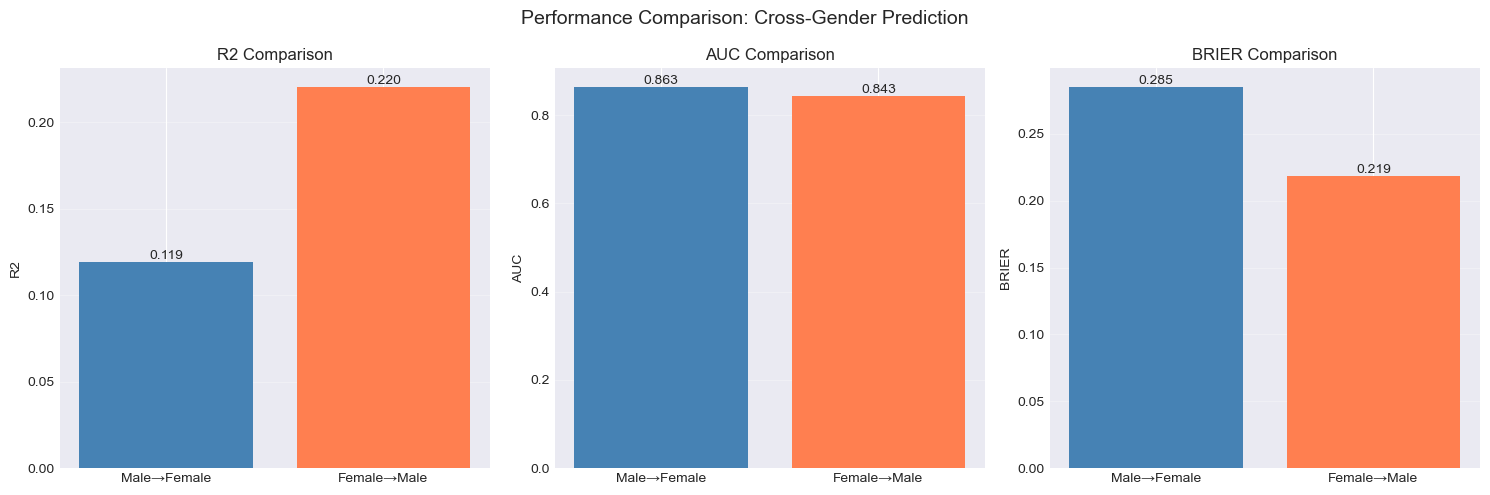

In [76]:
# Cell 12: Summary Comparison
def create_summary_table(validator: GenderCrossValidator) -> pd.DataFrame:
    """Create a summary comparison table of all experiments."""
    summary = []
    
    for exp_name, results in validator.results.items():
        metrics = results['metrics']
        summary.append({
            'Experiment': exp_name,
            'R²': f"{metrics['r2']:.4f}",
            'MSE': f"{metrics['mse']:.4f}",
            'AUC': f"{metrics['auc']:.4f}",
            'Log Loss': f"{metrics['log_loss']:.4f}",
            'Brier': f"{metrics['brier']:.4f}"
        })
    
    return pd.DataFrame(summary)

# Create and display summary
summary_df = create_summary_table(validator)
print("\n" + "="*60)
print("SUMMARY: Cross-Gender Model Performance")
print("="*60)
print(summary_df.to_string(index=False))

# Create a bar plot comparison
metrics_compare = ['r2', 'auc', 'brier']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, metric in zip(axes, metrics_compare):
    m2f_val = validator.results["Male→Female"]['metrics'][metric]
    f2m_val = validator.results["Female→Male"]['metrics'][metric]
    
    ax.bar(['Male→Female', 'Female→Male'], [m2f_val, f2m_val], 
           color=['steelblue', 'coral'])
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Comparison')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (label, val) in enumerate(zip(['Male→Female', 'Female→Male'], 
                                         [m2f_val, f2m_val])):
        ax.text(i, val, f'{val:.3f}', ha='center', va='bottom')

plt.suptitle('Performance Comparison: Cross-Gender Prediction', fontsize=14)
plt.tight_layout()
plt.show()

EXPERIMENT 1: Train on Male → Test on Female


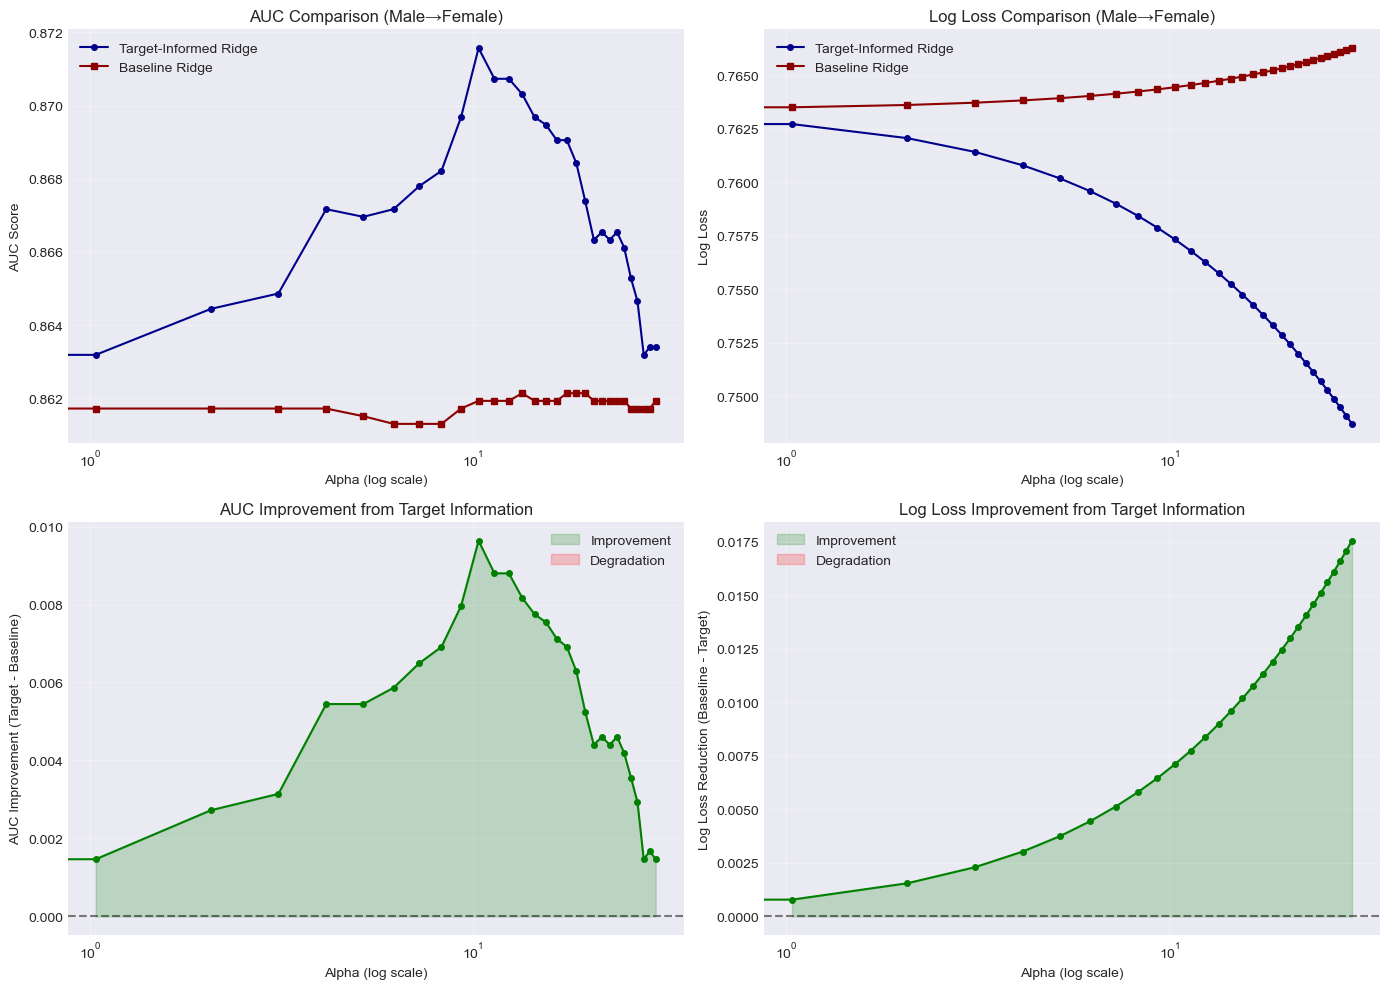


Optimal Alpha Values (by AUC):
  Target-Informed: α = 10.3448
    AUC = 0.8716
    Log Loss = 0.7573
  Baseline Ridge: α = 13.4483
    AUC = 0.8621
    Log Loss = 0.7647

EXPERIMENT 2: Train on Female → Test on Male


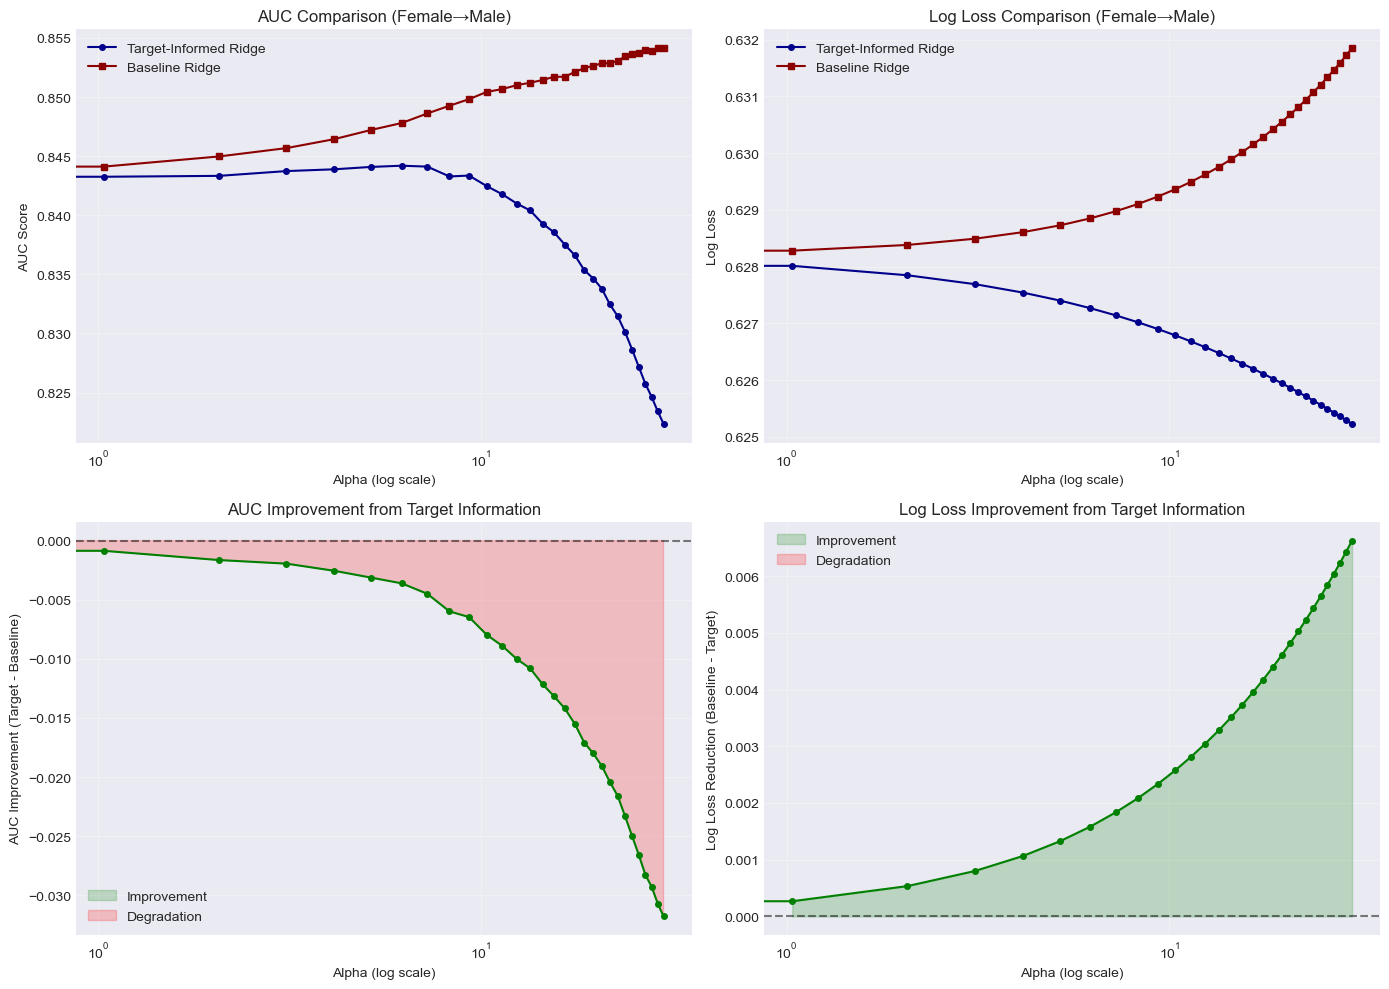


Optimal Alpha Values (by AUC):
  Target-Informed: α = 6.2069
    AUC = 0.8442
    Log Loss = 0.6273
  Baseline Ridge: α = 30.0000
    AUC = 0.8541
    Log Loss = 0.6319

SUMMARY: Maximum Improvements Across All Alphas

Male→Female:
  Max AUC improvement: 0.0096 at α = 10.3448
  Max Log Loss reduction: 0.0175 at α = 30.0000

Female→Male:
  Max AUC improvement: 0.0000 at α = 0.0000
  Max Log Loss reduction: 0.0066 at α = 30.0000


In [78]:
# Comparison of Target-Informed Ridge vs Baseline Ridge with Alpha Tuning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score, log_loss
from scipy.special import expit  # sigmoid function

def evaluate_models_with_alpha_sweep(
    train_data, 
    test_data, 
    target_coef, 
    feature_names,
    alphas=None,
    experiment_name="Experiment"
):
    """
    Compare Target-Informed Ridge vs Baseline Ridge across different alpha values.
    
    Args:
        train_data: Dict with 'X' and 'y' for training
        test_data: Dict with 'X' and 'y' for testing
        target_coef: Target coefficients for Target-Informed model
        feature_names: List of feature names
        alphas: Array of alpha values to test
        experiment_name: Name for this experiment
    
    Returns:
        DataFrame with results for both models
    """
    if alphas is None:
        alphas = np.linspace(0, 30, 30)
    
    results = []
    
    # Standardize features once
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(train_data['X'])
    X_test_std = scaler.transform(test_data['X'])
    y_train = train_data['y']
    y_test = test_data['y']
    
    for alpha in alphas:
        # 1. Target-Informed Ridge
        ti_model = TargetInformedModel(
            alpha=alpha,
            model_type="ridge",
            fit_intercept=True,
            targets=target_coef
        )
        ti_model.fit(X_train_std, y_train, feature_names=feature_names)
        
        # Target-informed predictions
        y_pred_ti = ti_model.predict(X_test_std)
        y_prob_ti = expit(y_pred_ti)  # Convert to probabilities
        
        # Target-informed metrics
        auc_ti = roc_auc_score(y_test, y_prob_ti)
        ll_ti = log_loss(y_test, np.clip(y_prob_ti, 1e-10, 1-1e-10))
        
        # 2. Baseline Ridge (no target information)
        baseline_model = Ridge(alpha=alpha, fit_intercept=True, random_state=42)
        baseline_model.fit(X_train_std, y_train)
        
        # Baseline predictions
        y_pred_baseline = baseline_model.predict(X_test_std)
        y_prob_baseline = expit(y_pred_baseline)
        
        # Baseline metrics
        auc_baseline = roc_auc_score(y_test, y_prob_baseline)
        ll_baseline = log_loss(y_test, np.clip(y_prob_baseline, 1e-10, 1-1e-10))
        
        # Store results
        results.append({
            'alpha': alpha,
            'auc_target': auc_ti,
            'logloss_target': ll_ti,
            'auc_baseline': auc_baseline,
            'logloss_baseline': ll_baseline,
            'auc_improvement': auc_ti - auc_baseline,
            'logloss_improvement': ll_baseline - ll_ti  # Lower is better for log loss
        })
    
    return pd.DataFrame(results)

def plot_model_comparison(results_df, experiment_name=""):
    """
    Create visualization comparing Target-Informed vs Baseline Ridge.
    
    Args:
        results_df: DataFrame from evaluate_models_with_alpha_sweep
        experiment_name: Title suffix for the plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: AUC comparison
    ax = axes[0, 0]
    ax.semilogx(results_df['alpha'], results_df['auc_target'], 
                'o-', label='Target-Informed Ridge', color='darkblue', markersize=4)
    ax.semilogx(results_df['alpha'], results_df['auc_baseline'], 
                's-', label='Baseline Ridge', color='darkred', markersize=4)
    ax.set_xlabel('Alpha (log scale)')
    ax.set_ylabel('AUC Score')
    ax.set_title(f'AUC Comparison {experiment_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Log Loss comparison
    ax = axes[0, 1]
    ax.semilogx(results_df['alpha'], results_df['logloss_target'], 
                'o-', label='Target-Informed Ridge', color='darkblue', markersize=4)
    ax.semilogx(results_df['alpha'], results_df['logloss_baseline'], 
                's-', label='Baseline Ridge', color='darkred', markersize=4)
    ax.set_xlabel('Alpha (log scale)')
    ax.set_ylabel('Log Loss')
    ax.set_title(f'Log Loss Comparison {experiment_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: AUC Improvement
    ax = axes[1, 0]
    ax.semilogx(results_df['alpha'], results_df['auc_improvement'], 
                'o-', color='green', markersize=4)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Alpha (log scale)')
    ax.set_ylabel('AUC Improvement (Target - Baseline)')
    ax.set_title('AUC Improvement from Target Information')
    ax.grid(True, alpha=0.3)
    
    # Shade positive improvement region
    ax.fill_between(results_df['alpha'], 0, results_df['auc_improvement'], 
                     where=(results_df['auc_improvement'] > 0), 
                     color='green', alpha=0.2, label='Improvement')
    ax.fill_between(results_df['alpha'], 0, results_df['auc_improvement'], 
                     where=(results_df['auc_improvement'] <= 0), 
                     color='red', alpha=0.2, label='Degradation')
    ax.legend()
    
    # Plot 4: Log Loss Improvement (lower is better, so positive = improvement)
    ax = axes[1, 1]
    ax.semilogx(results_df['alpha'], results_df['logloss_improvement'], 
                'o-', color='green', markersize=4)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Alpha (log scale)')
    ax.set_ylabel('Log Loss Reduction (Baseline - Target)')
    ax.set_title('Log Loss Improvement from Target Information')
    ax.grid(True, alpha=0.3)
    
    # Shade improvement regions
    ax.fill_between(results_df['alpha'], 0, results_df['logloss_improvement'], 
                     where=(results_df['logloss_improvement'] > 0), 
                     color='green', alpha=0.2, label='Improvement')
    ax.fill_between(results_df['alpha'], 0, results_df['logloss_improvement'], 
                     where=(results_df['logloss_improvement'] <= 0), 
                     color='red', alpha=0.2, label='Degradation')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Run experiments for both directions
print("="*60)
print("EXPERIMENT 1: Train on Male → Test on Female")
print("="*60)

results_m2f = evaluate_models_with_alpha_sweep(
    train_data=data_by_sex['male'],
    test_data=data_by_sex['female'],
    target_coef=targets['male'],
    feature_names=features_no_sex,
    experiment_name="Male→Female"
)

plot_model_comparison(results_m2f, "(Male→Female)")

# Find optimal alphas
best_ti_idx = results_m2f['auc_target'].idxmax()
best_baseline_idx = results_m2f['auc_baseline'].idxmax()

print("\nOptimal Alpha Values (by AUC):")
print(f"  Target-Informed: α = {results_m2f.loc[best_ti_idx, 'alpha']:.4f}")
print(f"    AUC = {results_m2f.loc[best_ti_idx, 'auc_target']:.4f}")
print(f"    Log Loss = {results_m2f.loc[best_ti_idx, 'logloss_target']:.4f}")
print(f"  Baseline Ridge: α = {results_m2f.loc[best_baseline_idx, 'alpha']:.4f}")
print(f"    AUC = {results_m2f.loc[best_baseline_idx, 'auc_baseline']:.4f}")
print(f"    Log Loss = {results_m2f.loc[best_baseline_idx, 'logloss_baseline']:.4f}")

print("\n" + "="*60)
print("EXPERIMENT 2: Train on Female → Test on Male")
print("="*60)

results_f2m = evaluate_models_with_alpha_sweep(
    train_data=data_by_sex['female'],
    test_data=data_by_sex['male'],
    target_coef=targets['female'],
    feature_names=features_no_sex,
    experiment_name="Female→Male"
)

plot_model_comparison(results_f2m, "(Female→Male)")

# Find optimal alphas for second experiment
best_ti_idx = results_f2m['auc_target'].idxmax()
best_baseline_idx = results_f2m['auc_baseline'].idxmax()

print("\nOptimal Alpha Values (by AUC):")
print(f"  Target-Informed: α = {results_f2m.loc[best_ti_idx, 'alpha']:.4f}")
print(f"    AUC = {results_f2m.loc[best_ti_idx, 'auc_target']:.4f}")
print(f"    Log Loss = {results_f2m.loc[best_ti_idx, 'logloss_target']:.4f}")
print(f"  Baseline Ridge: α = {results_f2m.loc[best_baseline_idx, 'alpha']:.4f}")
print(f"    AUC = {results_f2m.loc[best_baseline_idx, 'auc_baseline']:.4f}")
print(f"    Log Loss = {results_f2m.loc[best_baseline_idx, 'logloss_baseline']:.4f}")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY: Maximum Improvements Across All Alphas")
print("="*60)

max_auc_imp_m2f = results_m2f['auc_improvement'].max()
max_ll_imp_m2f = results_m2f['logloss_improvement'].max()
max_auc_imp_f2m = results_f2m['auc_improvement'].max()
max_ll_imp_f2m = results_f2m['logloss_improvement'].max()

print(f"\nMale→Female:")
print(f"  Max AUC improvement: {max_auc_imp_m2f:.4f} at α = {results_m2f.loc[results_m2f['auc_improvement'].idxmax(), 'alpha']:.4f}")
print(f"  Max Log Loss reduction: {max_ll_imp_m2f:.4f} at α = {results_m2f.loc[results_m2f['logloss_improvement'].idxmax(), 'alpha']:.4f}")

print(f"\nFemale→Male:")
print(f"  Max AUC improvement: {max_auc_imp_f2m:.4f} at α = {results_f2m.loc[results_f2m['auc_improvement'].idxmax(), 'alpha']:.4f}")
print(f"  Max Log Loss reduction: {max_ll_imp_f2m:.4f} at α = {results_f2m.loc[results_f2m['logloss_improvement'].idxmax(), 'alpha']:.4f}")

Prompt: LLM for Sex-Specific CAD Risk Model (Female-only version) You are an expert in biostatistics and cardiovascular epidemiology. Design a **logistic regression model to predict coronary artery disease (CAD)**. This model should represent **domain knowledge specifically for FEMALE patients** — not a general model, and not one meant for males. Your task is to propose reasonable coefficients that reflect how risk factors operate **among women**, using epidemiologic and clinical research evidence. Incorporate knowledge of how CAD presents differently in females and correct for historical male-centric bias in cardiovascular research. Emphasize patterns and risk pathways that are more predictive or distinctive for women (e.g., age-related risk acceleration after menopause, atypical chest pain, metabolic and stress-related risk factors). --- ### Model structure We use: \[ P(y=1|X) = \frac{1}{1 + \exp[-(β_0 + \sum_j β_j x_j)]} \] --- ### Feature encoding and scale All continuous predictors are **standardized** (z-scored) using means and standard deviations from a typical clinical dataset. Thus, each coefficient \(β_j\) reflects the change in log-odds of CAD per +1 SD increase in that variable. Binary/dummy predictors remain coded as {0,1}. **Continuous (z-scored, per +1 SD):** - age (years) - trestbps (resting blood pressure, mmHg) - chol (serum cholesterol, mg/dL) - thalach (maximum heart rate achieved, bpm) - oldpeak (ST depression, mm) **Binary / Dummy (0 or 1):** - exang (exercise-induced angina) - fbs (fasting blood sugar >120 mg/dL) - cp_2, cp_3, cp_4 (chest pain types vs. type 1 baseline) - restecg_1, restecg_2 (ECG dummies vs. normal baseline) --- ### What to provide 1. **Coefficients β_j (on this standardized scale):** - Ground directions and magnitudes in epidemiologic literature (e.g., Framingham, WISE, WHI, meta-analyses). - Larger positive β_j = higher CAD risk; negative β_j = protective (e.g., higher thalach). - Reflect *female-specific patterns*, such as: - Stronger influence of metabolic and inflammatory factors (fbs, oldpeak). - Weaker or more variable association of cholesterol with CAD. - Different presentation and interpretation of chest pain (cp_2–cp_4). - Slightly weaker link between exercise-induced angina and CAD compared with men. 2. **Intercept β₀:** - Represents the baseline log-odds of CAD for an average woman (all standardized continuous features = 0, binary = 0). - Choose a plausible baseline CAD prevalence for women (e.g., 5–10%) and convert to β₀ via logit(p). 3. **Confidence & Uncertainty (optional but useful):** - Indicate which coefficients are most certain (e.g., age, fbs, oldpeak) vs. more uncertain (e.g., ECG or chest pain types). --- ### Output format Return **only** strict JSON with the coefficients:
json
{
  "betas": {
    "intercept": ...,
    "age": ...,
    "trestbps": ...,
    "chol": ...,
    "thalach": ...,
    "oldpeak": ...,
    "exang": ...,
    "fbs": ...,
    "cp_2": ...,
    "cp_3": ...,
    "cp_4": ...,
    "restecg_1": ...,
    "restecg_2": ...
  }
}

prompt for females to males. 


custom_prompt_female_train = """ You are an expert in biostatistics and cardiovascular epidemiology. Propose a logistic regression model to predict CAD. This model will be used as a domain-knowledge-based predictor and later blended with data-driven models.

IMPORTANT CONTEXT: The model will be trained using only data from FEMALE patients, but it will later be evaluated on MALE patients (out-of-group prediction). When proposing coefficients, keep in mind that sex is coded (1 = male, 0 = female). The model must therefore generalize from female-specific training to male test cases.

MODEL FORM
We use: P(y=1|X) = 1 / (1 + exp(-(β0 + Σ_j β_j * x_j)))

FEATURE ENCODING AND SCALE
Continuous predictors are STANDARDIZED using means/SDs computed from the in-domain (Cleveland) cohort. Thus, each continuous coefficient β_j represents the change in log-odds per +1 standard deviation (SD) increase.
Binary/dummy predictors remain as {0,1}.

Continuous (z-scored, per +1 SD):
- age (years, standardized)
- trestbps (mmHg, standardized)
- chol (mg/dL, standardized)
- thalach (bpm, standardized)
- oldpeak (mm, standardized)

Binary / Dummy (0 or 1):
- sex (1 = male, 0 = female)
- exang (1 = exercise-induced angina, 0 = no)
- fbs (1 = fasting blood sugar >120 mg/dL, 0 = no)
- cp_2 (1 = chest pain type 2 vs type 1 baseline)
- cp_3 (1 = chest pain type 3 vs type 1 baseline)
- cp_4 (1 = chest pain type 4 vs type 1 baseline)
- restecg_1.0 (1 = ST-T abnormality vs normal baseline)
- restecg_2.0 (1 = LV hypertrophy vs normal baseline)

WHAT TO PROVIDE
1) Propose coefficients β_j ON THIS SCALE:
- Direction and approximate magnitude grounded in epidemiology (Framingham, meta-analyses, etc.).
- Larger positive β_j = higher CAD risk; negative β_j (e.g., thalach) = protective.
- Remember: coefficients will be trained on females but applied to males, so consider potential transfer issues (e.g., the “sex” coefficient reflects female-only training).

2) Intercept β0:
- Interpret β0 as the baseline log-odds for an average in-domain patient: all standardized continuous features at 0 (their cohort means), binary dummies at 0 (reference levels).
- Choose a plausible CAD baseline prevalence for such a reference, and convert to β0 via logit(p).

3) Confidence & Uncertainty:
- Indicate which coefficients are most certain (age, sex, diabetes/exang) vs more uncertain (chol, ECG dummies).

OUTPUT (STRICT JSON ONLY at the end; no extra text after):
{ "betas": { "intercept": ..., "age": ..., "sex": ..., "trestbps": ..., "chol": ..., "thalach": ..., "oldpeak": ..., "exang": ..., "fbs": ..., "cp_2": ..., "cp_3": ..., "cp_4": ..., "restecg_1.0": ..., "restecg_2.0": ... } } """

